In [1]:
import itertools
import skimage
from scipy.spatial.distance import pdist
import numpy as np

from sklearn import manifold
import torch
import torch.nn.functional as F
import torchvision

import sys
sys.path.append('../')
from paradime import dr as pddr
from paradime import relations as pdrel
from paradime import transforms as pdtf
from paradime import loss as pdloss
from paradime import utils as pdutils

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='../data',
    train=True,
    download=True,
    transform=transform,
)

testset = torchvision.datasets.CIFAR10(
    root='../data',
    train=False,
    download=True,
    transform=transform,
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_items = 20000
imgs = [ trainset[i][0] for i in range(num_items) ]
labels = [ trainset[i][1] for i in range(num_items) ]

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.conv3 = torch.nn.Conv2d(32, 64, 3)
        self.conv4 = torch.nn.Conv2d(64, 128, 3)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.dropout = torch.nn.Dropout(0.2)
        self.dense_class = torch.nn.Linear(512, 10)
        self.dense_emb = torch.nn.Linear(512, 2)

    def joint_forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 512)
        return x

    def classify(self, x):
        x = self.joint_forward(x)
        x = F.relu(self.dense_class(x))
        return x

    def embed(self, x):
        x = self.joint_forward(x)
        x = self.dense_emb(x)
        return x

In [6]:
dr = pddr.ParametricDR(
    model=Net(),
    dataset={
        'data': torch.stack(imgs).float(),
        'labels': torch.tensor(labels),
    },
    training_phases=[
        pddr.TrainingPhase(
            name='main',
            loss=pdloss.ClassificationLoss(),
            optimizer=torch.optim.SGD,
            learning_rate=0.01,
            epochs=40,
            batch_size=50,
            report_interval=5,
            momentum=0.9,
        )
    ],
    use_cuda=True,
    verbose=True,
)
dr.train()

2022-08-20 19:43:05,971: Registering dataset.
2022-08-20 19:43:05,980: Beginning training phase 'main'.
2022-08-20 19:43:07,371: Loss after epoch 0: 915.6332247257233
2022-08-20 19:43:13,226: Loss after epoch 5: 499.2969443798065
2022-08-20 19:43:19,137: Loss after epoch 10: 313.3205517530441
2022-08-20 19:43:25,259: Loss after epoch 15: 213.19895799458027
2022-08-20 19:43:31,232: Loss after epoch 20: 151.1768185645342
2022-08-20 19:43:37,297: Loss after epoch 25: 119.65112428739667
2022-08-20 19:43:43,336: Loss after epoch 30: 100.05477426946163
2022-08-20 19:43:49,379: Loss after epoch 35: 90.1053259652108


In [8]:
preds = dr.apply(dr.dataset.data['data'], 'classify').argmax(dim=1)

In [12]:
(preds == dr.dataset.data['labels']).sum() / num_items

tensor(0.9617)

In [23]:
latent = dr.apply(torch.stack(imgs)[:5000], 'joint_forward')

In [24]:
dists = pdrel.PDist().compute_relations(latent)

In [57]:
dr = pddr.ParametricDR(
    model=Net(),
    dataset={
        'data': torch.stack(imgs).float()[:5000],
        'labels': torch.tensor(labels)[:5000],
    },
    global_relations=pdrel.Precomputed(dists.to_triangular_tensor().data.float(),
        transform=[
            pdtf.ConnectivityBasedRescale(n_neighbors=50, bracket=[0.001, 100.]),
            pdtf.Symmetrize(subtract_product=True),
        ]
    ),
    batch_relations = pdrel.DistsFromTo(
        transform=[
            pdtf.ModifiedCauchyTransform()
        ]
    ),
    training_phases=[
        pddr.TrainingPhase(
            name='main',
            sampling='negative_edge',
            neg_sampling_rate=3,
            loss=pdloss.RelationLoss(loss_function=pdloss.cross_entropy_loss),
            learning_rate=0.005,
            epochs=30,
            batch_size=10,
            report_interval=2,
        )
    ],
    use_cuda=True,
    verbose=True,
)
dr.train()

2022-08-20 20:33:42,646: Registering dataset.
2022-08-20 20:33:42,672: Computing global relations 'rel'.
2022-08-20 20:33:42,840: Beginning training phase 'main'.


d:\Dokumente\Dissertation\paradime\notebooks\..\paradime\relations.py:120: UserWarning: Ignoring input for precomputed relations.
  warnings.warn("Ignoring input for precomputed relations.")


RuntimeError: number of categories cannot exceed 2^24

In [63]:
global_rels = pdrel.NeighborBasedPDist(
    transform=[
        pdtf.ConnectivityBasedRescale(n_neighbors=50, bracket=[0.001, 100.]),
        pdtf.Symmetrize(subtract_product=True),
    ]
)

In [64]:
foo = global_rels.compute_relations(latent)

ValueError: Expected vector-form relation tensor.

In [28]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [54]:
tsne = TSNE(metric='precomputed', perplexity=100)
emb = tsne.fit_transform(dists.to_square_array().data)

c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Andreas\miniconda3\envs\ml\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


<AxesSubplot:>

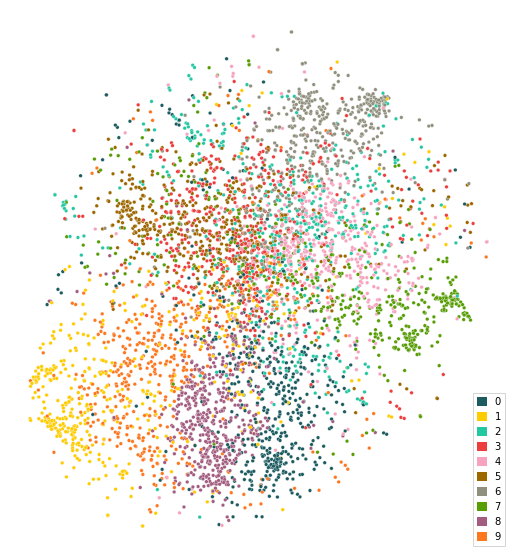

In [55]:
pdutils.plotting.scatterplot(emb, labels[:len(emb)])